# BAOAB method in Julia

# Simulating Langevin dynamics (from lecture note)

We assume we have some complicated potential energy function $U(q)$, and the target distribution $\rho_\beta(q)$ where 
$$\rho_\beta(q) = \frac1{Z_\beta} \exp(-\beta U(q)),\qquad Z_\beta=\int_{-\infty}^\infty \exp(-\beta U(q) )\,\rm{d}q.$$
Ultimately we want to compute averages with respect to this distribution, which we can write as an integral against $\rho_\beta(q)$.

If we augment our distribution to include momentum $p$, then we can write 
$$\rho_\beta(q,p) = \frac1{\hat{Z}_\beta} \exp(-\beta H(q,p) ),\qquad \hat{Z}_\beta=\int_{-\infty}^\infty \exp(-\beta H(q,p) )\,\rm{d}q\rm{d}p,$$
where $H$ is the familiar Hamiltonian, or total energy function, that we've seen before
$$H(q,p) = \frac12 \|p\|^2 + U(q)$$
where we have assumed mass is 1 for all degrees of freedom.   (It is easy to change this if we wanted to include a nonunit mass, but just complicates the notation a bit.)

As $q$ and $p$ are independent, we can integrate out over the momentum variables and recover the correct sampling in $q$.  This means that we can think of the momenta as intermediate or 'auxiliary' variables if our main goal is to compute averages of q-dependent functions.

The momentum variables are useful as they can allow a system to continue going in an unfavourable direction (i.e. up barriers) via inertia. This property is lacking in, for example, Brownian dynamics.

The equations of motion for Langevin dynamics are
$${ \begin{array}{rcl}
\dot{q} &=& p\\
\dot{p} &=& -\nabla U(q) - \gamma p + \sqrt{2\gamma /\beta} \dot{W}\end{array}}$$
where $W$ is a Wiener process, and $\gamma>0$ is the _friction constant_, a parameter that describes how rapidly energy is dissipated from the system to its surroundings as well as the rate at which the momentum is randomized ($\gamma$ should be viewed as a rate). Note that if $\gamma=0$ then the system reduces to the constant energy (Hamiltonian) dynamics that we looked at earlier in the term when we studied symplectic methods. If $\gamma$ is large, or infinite, then solutions will tend towards solutions to Brownian dynamics, as mentioned in lecture.   In between, $\gamma$ alters the way we converge to equilibrium (or the rate at which averages of functions taken along stochastic paths converge to their long term (ensemble) averages.

We can rewrite Langevin dynamics as the sum of three terms:


$$\left[ \begin{array}{c} \dot{q}\\ \dot{p} \end{array}\right]
= \underbrace{\left[\begin{array}{c} p \\0 \end{array}\right]}_\text{A}
+ \underbrace{\left[\begin{array}{c} 0\\F(q) \end{array}\right]}_\text{B}
+ \underbrace{\left[\begin{array}{c} 0\\-\gamma p + \sqrt{2\gamma/\beta} \dot{W} \end{array}\right]}_\text{O}.$$
As usual $F(q)=-\nabla U(q)$ denotes the force.

As discussed in lecture, we can solve each of the pieces _exactly_ in the weak (distributional) sense:

$$\text{(A) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) + h  p(t) \\
\qquad p(t+h)&\leftarrow&p(t)
\end{array}\right.$$

$$\text{(B) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
\qquad p(t+h)&\leftarrow&p(t) + h F(q(t))
\end{array}\right.$$

$$\text{(O) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
R(t+h)&\leftarrow& \text{Normal}(0,I)\\
\qquad p(t+h)&\leftarrow&\exp(-\gamma h) p(t) + \sqrt{1/\beta}\sqrt{1-\exp(-2\gamma h)} R(t+h)
\end{array}\right.$$

The solution of the O step comes from the solution for the Ornstein-Uhlenbeck process, with $R(t)\in\mathbb{R}^N$ a vector of independent and identically distributed (i.i.d.) normal random numbers.

In [1]:
function A_step(qp, h)
    q, p = qp
    q = q + h * p
    return [q, p]
end

function B_step(qp, h, force)
    q, p = qp
    F = force
    p = p + h * F
    return [q, p]
end

function O_step(qp, h, A, beta)
    q, p = qp
    alpha = exp(-h * A)
    R = randn(length(q))
    p = alpha * p + sqrt(1 / beta) * sqrt(1 - exp(-2 * h * A)) * R
    return [q, p]
end

function BAOAB_step(q, p, h, A, beta, force)
    qp = copy([q, p])
    qp = B_step(qp, h/2, force)
    qp = A_step(qp, h/2)
    qp = O_step(qp, h, A, beta)
    qp = A_step(qp, h/2)
    qp = B_step(qp, h/2, force)
    q, p = qp
    return q, p
end

BAOAB_step (generic function with 1 method)

In [2]:
function grad_gaussian(data, theta, N, n)
    # 1st model - Bayesian Inference for Gaussian Distribution
    mu, gamma = theta

    sigma_x = sum(data)
    sigma_x2 = sum((data .- mu).^2)

    d_mu = (N + 1) * mu * gamma - gamma * N * sigma_x / n 
    d_gamma = 1 - (N + 1) / (2 * gamma) + mu^2 / 2 + N * sigma_x2 / (2 * n)

    return [d_mu, d_gamma]
end

function run_simulation(q0, p0, Nsteps, h, A, beta, Samples, step_function, grad_U, N, n)
    # q_traj = copy(q0)'
    # p_traj = copy(p0)'
    q_traj = zeros(2,Nsteps)
    p_traj = zeros(2,Nsteps)
    t_traj = zeros(Nsteps)

    q = copy(q0)
    p = copy(p0)
    t = 0.0

    for i in 1:Nsteps
        idx = randperm(N)[1:n]
        data = Samples[idx]
        force = - grad_U(data, q, N, n)
        q, p = step_function(q, p, h, A, beta, force)
        t += h
        
        q_traj[:,i] = q
        p_traj[:,i] = p
        t_traj[i] = t
    end

    return q_traj, p_traj, t_traj
end

run_simulation (generic function with 1 method)

In [28]:
using Random

# Initialize one walker
q0 = [0,1]      # just for initialization
p0 = randn(2)

Nsteps = 1000000
h = 0.001
A = 10.0
beta = 1.0
N = 100
n = 10
Samples = randn(N)

# Run one long trajectory of Nsteps, using the BAOAB scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps, h, A, beta, Samples, BAOAB_step, grad_gaussian, N, n);

# calculate the real distribution
x_bar = sum(Samples)/N
mu_N = x_bar * N / (N+1);
kappa_N = N+1;
alpha_N = 1 + N/2;
beta_N = 1 + sum((Samples .- x_bar).^2) / 2 + N * x_bar^2 / (2 * (1+N));

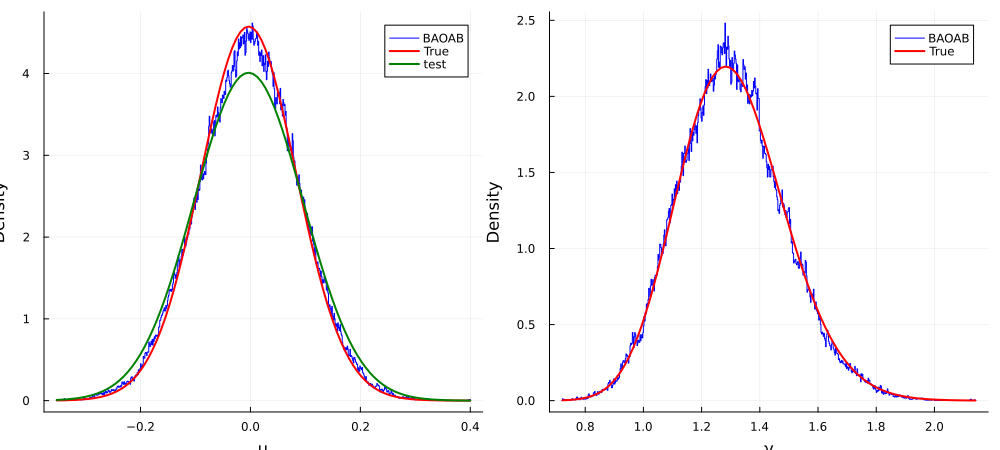

In [29]:
using Plots, Distributions

x1 = range(minimum(q_traj[1,:]), stop=maximum(q_traj[1,:]), length=100)
x2 = range(minimum(q_traj[2,:]), stop=maximum(q_traj[2,:]), length=100)
# q1_dis = pdf(Normal(mu_N, sqrt((kappa_N * 1)^-1)), x1)   # gamma = 1
v = 2 * alpha_N
std = sqrt(beta_N / (kappa_N*alpha_N))
tdist = TDist(v)
q1_dist = pdf(mu_N .+ std .* tdist, x1)
q2_dist = pdf(Gamma(alpha_N, 1/beta_N), x2)

q1_plot = stephist(q_traj[1,:], bins=1000, normalize=true, label="BAOAB", xlabel="μ", ylabel="Density", color="blue")
q2_plot = stephist(q_traj[2,:], bins=1000, normalize=true, label="BAOAB", xlabel="γ", ylabel="Density", color="blue")
plot!(q1_plot, x1, q1_dist, color="red", lw=2, label="True")
# plot!(q1_plot, x1, q1_dis, color="green", lw=2, label="test")
plot!(q2_plot, x2, q2_dist, color="red", lw=2, label="True")

plot(q1_plot, q2_plot, layout=(1,2), size=(1000, 450))